In [1]:
# !pip install pycountry
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from plotnine import *
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, svm, tree
from scipy import stats
import pycountry
from scipy.stats import linregress

# for linear regression 
from sklearn import linear_model
from scipy import stats

In [2]:
arms_sales = pd.read_csv('TIV-Import-All-1950-2020.csv')

# Filling all the NaN values with 0.0 for later calculation
arms_sales.fillna(value=0, inplace=True)
arms_sales_original = arms_sales
arms_sales.head()

,Country,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,4.0,7.0,89.0,254.0,...,523.0,235.0,288.0,116.0,174.0,252.0,349.0,382.0,227.0,16391.0
1,African Union**,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,79.0
2,Albania,20.0,10.0,11.0,20.0,22.0,132.0,98.0,42.0,47.0,...,15.0,7.0,7.0,7.0,0.0,4.0,2.0,5.0,0.0,2771.0
3,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,661.0,362.0,620.0,898.0,2903.0,1128.0,1284.0,164.0,549.0,32139.0
4,Amal (Lebanon)*,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0


In [3]:
#================================================
#============= Moving Data Around ===============
#================================================

# Sorting the values by the 'Total' of the row to find the highest values in the data.

arms_sales.sort_values(by=['Total'], ascending=False, inplace=True)

In [4]:
# Rearranging values, bringing 'Total' to the first column in the df.

cols = arms_sales.columns.tolist()
cols = cols[-1:] + cols[:-1]
# cols

arms_sales = arms_sales[cols] 
arms_sales.head()

,Total,Country,1950,1951,1952,1953,1954,1955,1956,1957,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
260,1973386.0,Total,8139.0,11497.0,16533.0,24027.0,20371.0,20147.0,24262.0,23556.0,...,30043.0,27995.0,27174.0,27073.0,28638.0,31438.0,31762.0,27028.0,27105.0,22831.0
94,126727.0,India,141.0,277.0,104.0,430.0,265.0,350.0,366.0,980.0,...,3598.0,4392.0,5381.0,3347.0,3117.0,3003.0,2909.0,1485.0,3075.0,2799.0
39,80828.0,China,2572.0,2197.0,3430.0,3144.0,3500.0,1730.0,2255.0,2126.0,...,1055.0,1571.0,1289.0,1077.0,1262.0,1139.0,1338.0,1962.0,1347.0,811.0
193,70781.0,Saudi Arabia,0.0,0.0,7.0,1.0,2.0,16.0,10.0,72.0,...,1222.0,1033.0,1614.0,2740.0,3377.0,2961.0,3931.0,3315.0,3419.0,2466.0
58,67745.0,Egypt,163.0,57.0,0.0,1.0,142.0,725.0,1065.0,479.0,...,630.0,281.0,673.0,420.0,1436.0,1690.0,2395.0,1677.0,1046.0,1311.0


In [5]:
# Dropping row that is the total of all values. Not useful for the analysis. This part is optional.

arms_sales = arms_sales.drop(labels=[260], axis=0)
arms_sales.head()

,Total,Country,1950,1951,1952,1953,1954,1955,1956,1957,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
94,126727.0,India,141.0,277.0,104.0,430.0,265.0,350.0,366.0,980.0,...,3598.0,4392.0,5381.0,3347.0,3117.0,3003.0,2909.0,1485.0,3075.0,2799.0
39,80828.0,China,2572.0,2197.0,3430.0,3144.0,3500.0,1730.0,2255.0,2126.0,...,1055.0,1571.0,1289.0,1077.0,1262.0,1139.0,1338.0,1962.0,1347.0,811.0
193,70781.0,Saudi Arabia,0.0,0.0,7.0,1.0,2.0,16.0,10.0,72.0,...,1222.0,1033.0,1614.0,2740.0,3377.0,2961.0,3931.0,3315.0,3419.0,2466.0
58,67745.0,Egypt,163.0,57.0,0.0,1.0,142.0,725.0,1065.0,479.0,...,630.0,281.0,673.0,420.0,1436.0,1690.0,2395.0,1677.0,1046.0,1311.0
103,65890.0,Japan,0.0,0.0,8.0,223.0,314.0,408.0,757.0,1059.0,...,268.0,205.0,252.0,307.0,329.0,330.0,441.0,654.0,899.0,724.0


In [6]:

df_1950_1960 = arms_sales[["Country",'1950','1951','1952','1953','1954','1955','1956','1957','1958', '1959']].copy(deep=True)
df_1950_1960["sum"] = df_1950_1960.sum(axis=1)
df_1960_1970 = arms_sales[["Country",'1960','1961','1962','1963','1964','1965','1966','1967','1968', '1969']].copy(deep=True)
df_1960_1970["sum"] = df_1960_1970.sum(axis=1)
df_1970_1980 = arms_sales[["Country",'1970','1971','1972','1973','1974','1975','1976','1977','1978', '1979']].copy(deep=True)
df_1970_1980["sum"] = df_1970_1980.sum(axis=1)
df_1980_1990 = arms_sales[["Country",'1980','1981','1982','1983','1984','1985','1986','1987','1988', '1989']].copy(deep=True)
df_1980_1990["sum"] = df_1980_1990.sum(axis=1)
df_1990_2000 = arms_sales[["Country",'1990','1991','1992','1993','1994','1995','1996','1997','1998', '1999']].copy(deep=True)
df_1990_2000["sum"] = df_1990_2000.sum(axis=1)
df_2000_2010 = arms_sales[["Country",'2000','2001','2002','2003','2004','2005','2006','2007','2008', '2009']].copy(deep=True)
df_2000_2010["sum"] = df_2000_2010.sum(axis=1)
df_2010_2020 = arms_sales[["Country",'2010','2011','2012','2013','2014','2015','2016','2017','2018', '2019','2020']].copy(deep=True)
df_2010_2020["sum"] = df_2010_2020.sum(axis=1)


df_1950_1960.reset_index(drop=True, inplace=True)
df_1960_1970.reset_index(drop=True, inplace=True)
df_1970_1980.reset_index(drop=True, inplace=True)
df_1980_1990.reset_index(drop=True, inplace=True)
df_1990_2000.reset_index(drop=True, inplace=True)
df_2000_2010.reset_index(drop=True, inplace=True)
df_2010_2020.reset_index(drop=True, inplace=True)


top_50_1950_1960 = df_1950_1960.head(50).copy(deep=True)
top_50_1960_1970 = df_1960_1970.head(50).copy(deep=True)
top_50_1970_1980 = df_1970_1980.head(50).copy(deep=True)
top_50_1980_1990 = df_1980_1990.head(50).copy(deep=True)
top_50_1990_2000 = df_1990_2000.head(50).copy(deep=True)
top_50_2000_2010 = df_2000_2010.head(50).copy(deep=True)
top_50_2010_2020 = df_2010_2020.head(50).copy(deep=True)

_1950_1960_float = list(top_50_1950_1960.sum(axis=0))
_1960_1970_float = list(top_50_1960_1970.sum(axis=0))
_1970_1980_float = list(top_50_1970_1980.sum(axis=0))
_1980_1990_float = list(top_50_1980_1990.sum(axis=0))
_1990_2000_float = list(top_50_1990_2000.sum(axis=0))
_2000_2010_float = list(top_50_2000_2010.sum(axis=0))
_2010_2020_float = list(top_50_2010_2020.sum(axis=0))


# _1950_1960_float = _1950_1960_float
# _1960_1970_float = _1960_1970_float
# _1970_1980_float = _1970_1980_float
# _1980_1990_float = _1980_1990_float
# _1990_2000_float = _1990_2000_float
# _2000_2010_float = _2000_2010_float
# _2010_2020_float = _2010_2020_float

# newList = [x / 5.0 for x in _1950_1960_float]

year_1950_1960 = [1950,1951,1952,1953,1954,1955,1956,1957,1958,1959]
year_1960_1970 = [1960,1961,1962,1963,1964,1965,1966,1967,1968,1969]
year_1970_1980 = [1970,1971,1972,1973,1974,1975,1976,1977,1978,1979]
year_1980_1990 = [1980,1981,1982,1983,1984,1985,1986,1987,1988,1989]
year_1990_2000 = [1990,1991,1992,1993,1994,1995,1996,1997,1998,1999]
year_2000_2010 =[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009]
year_2010_2020 = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

del _1950_1960_float[-1]
del _1960_1970_float[-1]
del _1970_1980_float[-1]
del _1980_1990_float[-1]
del _1990_2000_float[-1]
del _2000_2010_float[-1]
del _2010_2020_float[-1]

del _1950_1960_float[0]
del _1960_1970_float[0]
del _1970_1980_float[0]
del _1980_1990_float[0]
del _1990_2000_float[0]
del _2000_2010_float[0]
del _2010_2020_float[0]

_1950_1960 = np.array(_1950_1960_float, dtype = np.int32)
_1960_1970 = np.array(_1960_1970_float, dtype = np.int32)
_1970_1980 = np.array(_1970_1980_float, dtype = np.int32)
_1980_1990 = np.array(_1980_1990_float, dtype = np.int32)
_1990_2000 = np.array(_1990_2000_float, dtype = np.int32)
_2000_2010 = np.array(_2000_2010_float, dtype = np.int32)
_2010_2020 = np.array(_2010_2020_float, dtype = np.int32)

_1950_1960 = np.divide(_1950_1960, 50)
_1960_1970 = np.divide(_1960_1970, 50)
_1970_1980 = np.divide(_1970_1980, 50)
_1980_1990 = np.divide(_1980_1990, 50)
_1990_2000 = np.divide(_1990_2000, 50)
_2000_2010 = np.divide(_2000_2010, 50)
_2010_2020 = np.divide(_2010_2020, 50)

# slope, intercept, r_value, p_value, std_err = stats.linregress(year_1950_1960,_1950_1960)
# plt _1950_1960
# plt.plot(year_1950_1960, intercept + slope*year_1950_1960, c=np.random.rand(3,),label='linear regression line')
# plt.show()

# slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(year_1960_1970,_1960_1970)
#plt.plot(year_1960_1970, intercept + slope*year_1950_1960, c=np.random.rand(3,),label='linear regression line')

# slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(year_1970_1980,_1970_1980)
# slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(year_1980_1990,_1980_1990)
# slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(year_1990_2000,_1990_2000)
# slope5, intercept5, r_value5, p_value5, std_err5 = stats.linregress(year_2000_2010,_2000_2010)
# slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(year_2010_2020,_2010_2020)

# print(slope, intercept, r_value, p_value, std_err)
# del _1950_1960[0]
# _1950_1960
# top_50_1950_1960.head()
# type(_1950_1960[0])



In [7]:
# figure, axes = plt.subplots(nrows=3, ncols=3)
# plt.subplot(3,3,1)

# plt.plot(year_1950_1960, m*year_1950_1960 + b)
# plt.subplot(3,3,2)
# scatter_years_imports(top_50_1960_1970)
# plt.subplot(3,3,3)
# scatter_years_imports(top_50_1970_1980)
# scatter_years_imports(top_50_1970_1980)
# scatter_years_imports(top_50_1980_1990)
# scatter_years_imports(top_50_1990_2000)
# scatter_years_imports(top_50_2000_2010)
# scatter_years_imports(top_50_2010_2020)

In [8]:
#================================================
#================================================
# Individual plots and fitting regression models 
#================================================
#================================================

#================================================
#================= 1950-1960 ====================
#================================================

# def scatter_years_imports(data_frame):
#     countries = data_frame['Country'].tolist()
#     years = data_frame.columns.tolist()[1:11]
#     country_list = list(set(countries))
#     # country_to_color = { i : np.random.rand(3,) for i in country_list }
#     year_values = []
#     imports = []
#     for country in countries:
#         for year in years:
#             temp_year = int(year)
#             country_to_color = { i : np.random.rand(3,) for i in country_list }
#             if len(data_frame.index[data_frame['Country'] == country]) > 0:
#                 country_index = data_frame.index[data_frame['Country'] == country][0]
#                 import_value = data_frame.at[country_index, temp_year]
#                 year_values.append(temp_year)
#                 imports.append(import_value)
#                 plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc="upper left", labels=country_list)
#                 plt.rc('figure', figsize=(10, 10))
#                 plt.scatter(temp_year, import_value, color=country_to_color[country])
#                 # plt.scatter(year_values, imports, color=country_to_color[country])

#     return (year_values, imports)

# def scatter_years_imports(data_frame):
#     countries = data_frame['Country'].tolist()
#     years = data_frame.columns.tolist()[1:11]
#     country_list = list(set(countries))
#     # country_to_color = { i : np.random.rand(3,) for i in country_list }
#     year_values = []
#     imports = []
#     for country in countries:
#         for year in years:
#             temp_year = int(year)
#             country_to_color = { i : np.random.rand(3,) for i in country_list }
#             if len(data_frame.index[data_frame['Country'] == country]) > 0:
#                 country_index = data_frame.index[data_frame['Country'] == country][0]
#                 import_value = data_frame.at[country_index, year]
#                 # year_values.append(temp_year)
#                 # imports.append(import_value)
#                 plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc="upper left", labels=country_list)
#                 plt.rc('figure', figsize=(10, 10))
#                 plt.scatter(temp_year, import_value, color=country_to_color[country])
#                 # plt.scatter(year_values, imports, color=country_to_color[country])

# def scatter_years_imports(data_frame):
#     countries = data_frame['Country'].tolist()
#     years = data_frame.columns.tolist()[1:11]
#     country_list = list(set(countries))
#     year_values = []
#     imports = []
#     for country in countries:
#         for year in years:
#             country_to_color = { i : np.random.rand(3,) for i in country_list }
#             if len(data_frame.index[data_frame['Country'] == country]) > 0:
#                 country_index = data_frame.index[data_frame['Country'] == country][0]
#                 import_value = data_frame.at[country_index, year]
#                 temp_year = int(year)
#                 # year_values.append(year)
#                 # imports.append(import_value)
#                 plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc="upper left", labels=country_list)
#                 plt.rc('figure', figsize=(10, 10))
#                 plt.scatter(temp_year, import_value, color=country_to_color[country])
#                 # plt.scatter(year_values, imports, color=country_to_color[country])


def scatter_years_imports(data_frame):
    countries = data_frame['Country'].tolist()
    years = data_frame.columns.tolist()[1:11]
    country_list = list(set(countries))
    year_values = []
    imports = []
    for country in countries:
        for year in years:
            country_to_color = { i : np.random.rand(3,) for i in country_list }
            if len(data_frame.index[data_frame['Country'] == country]) > 0:
                country_index = data_frame.index[data_frame['Country'] == country][0]
                import_value = data_frame.at[country_index, year]
                # year_values.append(year)
                # imports.append(import_value)
                temp_year = int(year)
                plt.legend(bbox_to_anchor=(1.05, 1), ncol=2, loc="upper left", labels=country_list)
                plt.rc('figure', figsize=(10, 10))
                plt.scatter(temp_year, import_value, color=country_to_color[country])
                # plt.scatter(year_values, imports, color=country_to_color[country])

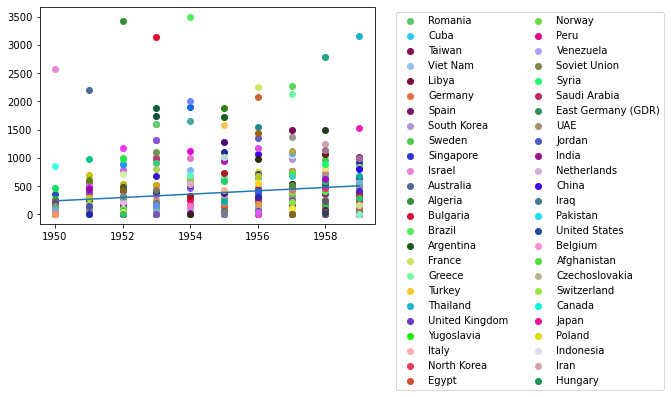

In [9]:
m,b = np.polyfit(year_1950_1960, _1950_1960, 1)
regression_line = [(m*x)+b for x in year_1950_1960]
scatter_years_imports(top_50_1950_1960)
plt.plot(year_1950_1960, regression_line)
plt.show()

# scatter_years_imports(top_50_1970_1980)
# scatter_years_imports(top_50_1980_1990)
# scatter_years_imports(top_50_1990_2000)
# scatter_years_imports(top_50_2000_2010)
# scatter_years_imports(top_50_2010_2020)

In [10]:
# plt.title("1950-1960")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_1950_1960)

In [11]:
# plt.title("1960-1970")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_1960_1970)

In [12]:
# plt.title("1970-1980")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_1970_1980)

In [13]:
# plt.title("1980-1990")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_1980_1990)

In [14]:
# plt.title("1990-2000")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_1990_2000)

In [15]:
# plt.title("2000-2010")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_2000_2010)

In [16]:
# plt.title("2010-2020")
# plt.xlabel("Years")
# plt.ylabel("Imports")
# scatter_years_imports(top_50_2010_2020)

In [17]:
# def alpha3code(column):
#     CODE=[]
#     for country in column:
#         try:
#             code=pycountry.countries.get(name=country).alpha_3
#            # .alpha_3 means 3-letter country code 
#            # .alpha_2 means 2-letter country code
#             CODE.append(code)
#         except:
#             CODE.append('None')
#     return CODE
# # create a column for code 
# top_50_1950_1960['CODE']=alpha3code(top_50_1950_1960['Country'].tolist())
# top_50_1950_1960

In [18]:
# # first let us merge geopandas data with our data
# # 'naturalearth_lowres' is geopandas datasets so we can use it directly
# world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# # rename the columns so that we can merge with our data
# world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# # then merge with our data 
# merge=pd.merge(world,df,on='CODE')
# # last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
# location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
# merge=merge.merge(location,on='name').sort_values(by='Fatalities',ascending=False).reset_index()